In [ ]:

from shapely.geometry import Point
import pandas as pd
from math import sqrt
import geopandas as gpd
import re
import numpy as np
from rapidfuzz import process, fuzz
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')
pd.set_option('display.max_columns', None)
df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')
pd.set_option('display.max_columns', None)


C:\Users\gabri\AppData\Local\Temp\ipykernel_21672\227656833.py:21: DtypeWarning: Columns (11,12,17,18,20,21,22,23,25,26,27,28,29,30,31,32,33,36,37,39,40,42,43,44,45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dados/SpSafe_2022.csv', delimiter=';')


<h2 style="text-align: center;">Aprendizagem supervisionado</h2>


<p> A baixo, usarei dois algoritmo mais eficentes de aprendizagem supervisionado para tentar prever a quantidade de crimes de uma cidade usando algumas novas features como pib percapita e taxa de escolarização </p>
<a href="cidades.ibge.gov.br/brasil/sp/sao-paulo/panorama>">Referência: IBGE</a>

In [96]:
df_cidades = pd.read_csv('SpSafe_2022_cidades.csv', delimiter=',')
df_cidades["pib_2021"] = 0

In [97]:
renda = pd.read_csv('dados/mapa.csv', delimiter=',')
escolas = pd.read_csv('dados/mapa_educacao.csv', delimiter=',')

In [98]:
renda.rename(columns={' "PIB per capita"': 'pib_per_capita'}, inplace=True)
escolas.rename(columns={' "Taxa de escolarização de 6 a 14 anos de idade"': 'taxa_escolarizacao'}, inplace=True)

In [99]:

df_cidades = df_cidades.merge(
    renda[['Local', 'pib_per_capita']],
    left_on='CIDADE',
    right_on='Local',
    how='left'
)

In [100]:
df_cidades = df_cidades.merge(
    escolas[['Local', 'taxa_escolarizacao']],
    left_on='CIDADE',
    right_on='Local',
    how='left'
)   

In [101]:
df_cidades.head()

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K,IDMH,cod_ibge,cod_ra,reg_administrativa,reg_metropolitanas,ideb2019,pib_2021,Local_x,pib_per_capita,Local_y,taxa_escolarizacao
0,São Paulo,251285,11429865,2198.0,0.80,3550308,681,RM de São Paulo,RM de Sao Paulo,4.1,0,São Paulo,66872.84,São Paulo,96.0
1,Santo André,16033,752784,2130.0,0.81,3547809,681,RM de São Paulo,RM de Sao Paulo,4.5,0,Santo André,45062.56,Santo André,97.4
2,Campinas,13731,1140133,1204.0,0.80,3509502,686,RA de Campinas,RM de Campinas,4.4,0,Campinas,59634.21,Campinas,96.0
3,Guarulhos,12815,1293335,991.0,0.76,3518800,681,RM de São Paulo,RM de Sao Paulo,4.2,0,Guarulhos,55084.22,Guarulhos,97.1
4,São Bernardo do Campo,11086,811198,1367.0,0.80,3548708,681,RM de São Paulo,RM de Sao Paulo,4.4,0,São Bernardo do Campo,68571.36,São Bernardo do Campo,97.6


<p> Filtrando outliers para diminuir o overlift </p>

In [ ]:

df_sem_outliers = df_cidades[df_cidades['QUANTIDADE_CRIMES'] < 50000]
df_sem_outliers.head()

,CIDADE,QUANTIDADE_CRIMES,QUANTIDADE_POPULACAO,CRIMES_POR_100K,IDMH,cod_ibge,cod_ra,reg_administrativa,reg_metropolitanas,ideb2019,pib_2021,Local_x,pib_per_capita,Local_y,taxa_escolarizacao
1,Santo André,16033,752784,2130.0,0.81,3547809,681,RM de São Paulo,RM de Sao Paulo,4.5,0,Santo André,45062.56,Santo André,97.4
2,Campinas,13731,1140133,1204.0,0.80,3509502,686,RA de Campinas,RM de Campinas,4.4,0,Campinas,59634.21,Campinas,96.0
3,Guarulhos,12815,1293335,991.0,0.76,3518800,681,RM de São Paulo,RM de Sao Paulo,4.2,0,Guarulhos,55084.22,Guarulhos,97.1
4,São Bernardo do Campo,11086,811198,1367.0,0.80,3548708,681,RM de São Paulo,RM de Sao Paulo,4.4,0,São Bernardo do Campo,68571.36,São Bernardo do Campo,97.6
5,Osasco,9412,731127,1287.0,0.77,3534401,681,RM de São Paulo,RM de Sao Paulo,4.1,0,Osasco,122765.64,Osasco,96.0


<h2 style = 'text-align: center;'> Random Forest </h2>

In [126]:

X = df_sem_outliers [['IDMH', 'CRIMES_POR_100K','QUANTIDADE_POPULACAO', 'pib_per_capita', 'taxa_escolarizacao']]
y = df_sem_outliers ['QUANTIDADE_CRIMES']

# Dividir                                                           
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Avaliação
print("R²:", r2_score(y_test, y_pred))



# Importância das features
importances = model.feature_importances_
for nome, imp in zip(X.columns, importances):
    print(f"{nome}: {imp:.2f}")




R²: 0.9876687237935213
IDMH: 0.01
CRIMES_POR_100K: 0.08
QUANTIDADE_POPULACAO: 0.89
pib_per_capita: 0.01
taxa_escolarizacao: 0.01


<p > Testando o modelo com o um aumento de 0,65% de suas features, conforme previsão de crescimento para o ano de 2023</p>

In [ ]:
# Seleciona 4 amostras aleatórias
amostras = df_cidades.sample(n=4, random_state=42)

colunas_usadas = ['IDMH', 'CRIMES_POR_100K', 'QUANTIDADE_POPULACAO', 'pib_per_capita', 'taxa_escolarizacao']
X_amostras = amostras[colunas_usadas].copy()


X_modificado = X_amostras * 1.0065


predicoes = model.predict(X_modificado)

resultado = X_amostras.copy()
resultado.columns = [f"{col}_original" for col in resultado.columns]

for col in colunas_usadas:
    resultado[f"{col}_+0.65%"] = X_modificado[col].values


resultado["crimes_previstos"] = predicoes.astype(int)
resultado["CIDADE"] = amostras["CIDADE"].values
resultado["crimes_reais"] = amostras["QUANTIDADE_CRIMES"].values


colunas_final = ["CIDADE", "crimes_reais", "crimes_previstos"] + \
                [col for col in resultado.columns if col not in ["CIDADE", "crimes_reais", "crimes_previstos"]]

resultado = resultado[colunas_final].reset_index(drop=True)


resultado.style.set_caption("Simulação: crimes reais vs. previsão após acréscimo de 0,65% nos atributos")

 





,CIDADE,crimes_reais,crimes_previstos,IDMH_original,CRIMES_POR_100K_original,QUANTIDADE_POPULACAO_original,pib_per_capita_original,taxa_escolarizacao_original,IDMH_+0.65%,CRIMES_POR_100K_+0.65%,QUANTIDADE_POPULACAO_+0.65%,pib_per_capita_+0.65%,taxa_escolarizacao_+0.65%
0,Francisco Morato,840,866,0.700000,508.000000,165435,10439.010000,95.800000,0.704550,511.302000,166510.327500,10506.863565,96.422700
1,Caiuá,2,1,0.690000,36.000000,5492,15997.160000,99.300000,0.694485,36.234000,5527.698000,16101.141540,99.945450
2,Jaú,427,410,0.770000,320.000000,133548,36376.160000,97.800000,0.775005,322.080000,134416.062000,36612.605040,98.435700
3,Apiaí,29,28,0.710000,118.000000,24477,37278.880000,97.300000,0.714615,118.767000,24636.100500,37521.192720,97.932450


<h2 style = 'text-align: center'> Gradient Boosting Regressor </h2>

In [106]:

# Imputação de valores ausentes e treinamento com 
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


model2 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model2.fit(X_train_imputed, y_train)


y_pred2 = model2.predict(X_test_imputed)
print("R²:", r2_score(y_test, y_pred2))


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Erro médio de {rmse:.2f} crimes por cidade")


R²: 0.991417717136144
Erro médio de 146.81 crimes por cidade


<p>Testando com a mesma amostra testada com o random florest </p>

In [ ]:
predicoes_grad = model2.predict(X_modificado)

# Adiciona previsão, cidade e valor real de crimes
resultado["crimes_previstos"] = predicoes_grad.astype(int)
resultado["CIDADE"] = amostras["CIDADE"].values
resultado["crimes_reais"] = amostras["QUANTIDADE_CRIMES"].values

colunas_final = ["CIDADE", "crimes_reais", "crimes_previstos"] + \
                [col for col in resultado.columns if col not in ["CIDADE", "crimes_reais", "crimes_previstos"]]

resultado = resultado[colunas_final].reset_index(drop=True)


resultado.style.set_caption("Simulação: crimes reais vs. previsão após acréscimo de 0,65% nos atributos")

 

c:\Users\gabri\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


,CIDADE,crimes_reais,crimes_previstos,IDMH_original,CRIMES_POR_100K_original,QUANTIDADE_POPULACAO_original,pib_per_capita_original,taxa_escolarizacao_original,IDMH_+0.65%,CRIMES_POR_100K_+0.65%,QUANTIDADE_POPULACAO_+0.65%,pib_per_capita_+0.65%,taxa_escolarizacao_+0.65%
0,Francisco Morato,840,826,0.700000,508.000000,165435,10439.010000,95.800000,0.704550,511.302000,166510.327500,10506.863565,96.422700
1,Caiuá,2,3,0.690000,36.000000,5492,15997.160000,99.300000,0.694485,36.234000,5527.698000,16101.141540,99.945450
2,Jaú,427,413,0.770000,320.000000,133548,36376.160000,97.800000,0.775005,322.080000,134416.062000,36612.605040,98.435700
3,Apiaí,29,38,0.710000,118.000000,24477,37278.880000,97.300000,0.714615,118.767000,24636.100500,37521.192720,97.932450


<h2 style="text-align: center;">Aprendizagem não-supervisionado</h2>


<p>Neo aprendizado não-supervisionado, irei usar o algoritmo kmeans para encontrar relações entre as features, e a criação de 3 grupos </p>

C:\Users\gabri\AppData\Local\Temp\ipykernel_21672\2315566610.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_outliers['grupo'] = kmeans.fit_predict(X_scaled)


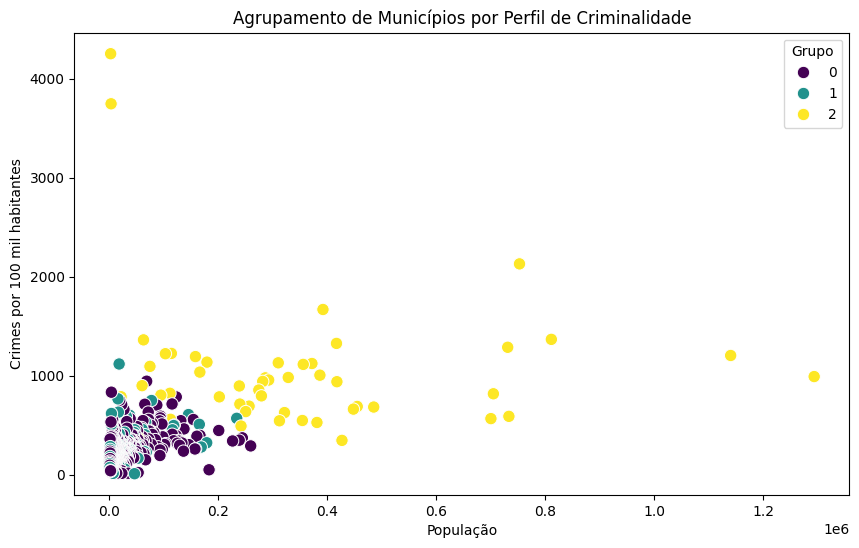

In [129]:
from sklearn.impute import SimpleImputer

var = ['QUANTIDADE_POPULACAO', 'IDMH', 'CRIMES_POR_100K', 'pib_per_capita', 'taxa_escolarizacao']
X = df_sem_outliers[var]

# Imputar valores ausentes com a média
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

kmeans = KMeans(n_clusters=3, random_state=42)
df_sem_outliers['grupo'] = kmeans.fit_predict(X_scaled)

# 📊 Visualizar os grupos (usando população vs crimes por 100k)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_sem_outliers,
    x='QUANTIDADE_POPULACAO',
    y='CRIMES_POR_100K',
    hue='grupo',
    palette='viridis',
    s=80
)
plt.title("Agrupamento de Municípios por Perfil de Criminalidade")
plt.xlabel("População")
plt.ylabel("Crimes por 100 mil habitantes")
plt.legend(title="Grupo")
plt.show()

In [130]:
# Calcular a média das variáveis por grupo
colunas = ['QUANTIDADE_POPULACAO', 'IDMH', 'CRIMES_POR_100K', 'pib_per_capita', 'taxa_escolarizacao']
medias_por_grupo = df_sem_outliers.groupby('grupo')[colunas].mean().round(2)
medias_por_grupo.reset_index(inplace=True)

# Visualizar
medias_por_grupo



,grupo,QUANTIDADE_POPULACAO,IDMH,CRIMES_POR_100K,pib_per_capita,taxa_escolarizacao
0,0,28042.73,0.74,221.96,41531.88,98.52
1,1,26503.86,0.71,243.33,31464.51,96.38
2,2,337901.39,0.77,1028.39,88988.92,97.40
